In [15]:
import tensorflow as tf 
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Common_Functions as cf 
from mpl_toolkits import mplot3d
import matplotlib
matplotlib.rcParams.update({'legend.fontsize': 12})
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from scipy import stats

In [16]:
from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1.keras.backend import clear_session
from tensorflow.compat.v1.keras.backend import get_session

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.Session(config=config))

In [17]:
df_pions = np.array(pd.read_csv('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Djuna_Data_Generation_Notebook/noshift1.csv',header = None))
pi = np.array(pd.read_csv('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Training_Data/symetric_training_data_pi.csv',header= None))
dpi = np.array(pd.read_csv('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Training_Data/symetric_training_data_dpi.csv',header= None))
V = np.array(pd.read_csv('/home/sean/Documents/Work/Level 4/Level-4-Masters-Project/Training_Data/symetric_training_data_V.csv',header = None))
df_pions = np.hstack((pi,dpi,V))
np.random.shuffle(df_pions)
train_x, train_y = cf.data_normaliser(df_pions[:-1000,:-2]), df_pions[:-1000,-1]
val_x, val_y = cf.data_normaliser(df_pions[-1000:,:-2]), df_pions[-1000:,-1]

In [18]:
opt = keras.optimizers.Adam(learning_rate= 0.005, beta_1 = 0.881, beta_2= 0.99)

In [19]:
def neg_grad_tester(val_array, array):
    quart_length = int(len(val_array)/3)
    #print(quart_length)
    x = np.arange(len(val_array[:-quart_length]))
    lin_reg_val = stats.linregress(x,val_array[:-quart_length])
    lin_reg = stats.linregress(x,array[:-quart_length])
   
    if lin_reg_val.slope < lin_reg.slope*0.6:
        return True
    else:
        return False

In [20]:

def layers_tester(size_range,size_spacing,layer_range,repeats,section = 100000,epochs = 100):
    epoch_no = epochs
    # Unpack Args
    min_size, max_size = size_range
    layer_min , layer_max = layer_range
    #Check input
    if (max_size-min_size)/size_spacing == int: 
        raise Exception('Spacing Must Be Integer')
    else:
        ##Results array's sizes: 
        size_steps = int((max_size-min_size)/size_spacing)+1
        size_list = np.arange(start =int(min_size),stop = 1+(int(max_size)),step= size_spacing, dtype  = int)
        layer_range_list = range(layer_min,1+layer_max)
        #Result Containers
        min_mae = np.zeros((size_steps,len(layer_range_list),repeats)) ###Axis 0:Size of Layers 1:Number of Layers 3:Number of repeats to take average over.
        is_last_val_bool = np.zeros((len(size_list),len(layer_range_list)))
        hist_list = []
        ## Neural Network Testing
        for i in range(len(size_list)):
            #print('Layers of Size',size_list[i])
            for j in range(len(layer_range_list)):
                
                #print(layer_range_list[j],'Layers Deep')
                loop_layer_shape = size_list[i]*np.ones((layer_range_list[j]))
                #print(loop_layer_shape)
                ## Reset val bool for loop
                last_val_bool = 0
                for k in range(repeats):
                    df = pd.DataFrame(cf.trained_network(train_x[:section],train_y[:section],val_x,val_y,loop_layer_shape, optimizer= opt, verbose= 0,epochs = epoch_no ).history)
                    val_mae_ar_smoothed = cf.exponetial_smoothing(np.array(df['val_mean_absolute_error']),0.4)
                    mae_ar_smoothed = cf.exponetial_smoothing(np.array(df['mean_absolute_error']),0.4)
                    min_mae[i,j,k] = np.min(val_mae_ar_smoothed)
                    if neg_grad_tester(val_mae_ar_smoothed,mae_ar_smoothed):
                        last_val_bool +=1
                        print('Negative Grad Identified')
                    else:
                        pass
                
                
                if last_val_bool >= 2:
                    is_last_val_bool[i,j] = 1
                else:
                    is_last_val_bool[i,j] = 0
                ## Record one Dataframe per loop 
                hist_list.append(df)
                ##plotting 
                epochs = np.arange(1,epoch_no+1)
                mae = df['mean_absolute_error']
                val_mae_smooth = cf.exponetial_smoothing(np.array(df['val_mean_absolute_error']),0.5)
                loss = df['loss']
                val_loss_smooth = cf.exponetial_smoothing(np.array(df['val_loss']),0.5)


                #plot while run for fun
                fig, axs  = plt.subplots(1,2, figsize= (14,5))
                fig.suptitle('Size{} '.format(size_list[i])+'Depth{}'.format(layer_range_list[j]))
                axs[0].plot(epochs,mae, c = 'black',linestyle = '--',label = 'Mean Absolute Error')
                axs[0].plot(epochs,val_mae_smooth,c = 'red', label = 'Smoothed Validation Mean Absolute Error')
                axs[0].set_xlabel('Training Epochs')

                axs[0].legend()


                axs[1].plot(epochs,loss, label = 'Loss',c = 'black',linestyle = '--')
                axs[1].plot(epochs,val_loss_smooth, label = 'Smoothed Validation Loss',c = 'red')
                axs[1].set_xlabel('Training Epochs')

                axs[1].legend()
                plt.show()
                
                
        return min_mae , layer_range_list, size_list, hist_list, is_last_val_bool


In [21]:
min_mape , layers, layer_sizes, histories, last_value = layers_tester((10,510),50,(4,10),1, epochs = 50)

KeyboardInterrupt: 

In [ ]:
min_mape_2d = min_mape.reshape(min_mape.shape[0],-1)
np.savetxt('Min_Mape_of_varying_layer_shapes.csv',min_mape_2d,delimiter=',')

In [28]:
min_mape_mean_load = np.loadtxt('Min_Mape_of_varying_layer_shapes.csv',delimiter=',')
#min_mape_mean_load = min_mape_mean_load.reshape(4,10,5)
min_mape_mean  = np.mean(min_mape,axis = 2)

min_index = np.where(np.min(min_mape_mean)==min_mape_mean)
min_mape_mean[np.where(min_mape_mean >0.05)] = 0.05 

print(min_mape)

[[[0.04903059]
  [0.04850792]
  [0.04774935]
  [0.04682463]
  [0.10370754]
  [0.04810873]
  [0.04911978]]

 [[0.04007043]
  [0.03986759]
  [0.03969089]
  [0.0396898 ]
  [0.04004557]
  [0.0394758 ]
  [0.03989949]]

 [[0.03915284]
  [0.03946188]
  [0.03970568]
  [0.03958044]
  [0.03852706]
  [0.03921   ]
  [0.03866564]]

 [[0.03866802]
  [0.03793002]
  [0.03947154]
  [0.03891097]
  [0.03891295]
  [0.03825257]
  [0.03910179]]

 [[0.03809177]
  [0.0385804 ]
  [0.03889144]
  [0.03829629]
  [0.03783848]
  [0.03847371]
  [0.03846404]]

 [[0.03817668]
  [0.03882796]
  [0.03851853]
  [0.03816376]
  [0.03862129]
  [0.03885673]
  [0.03857066]]

 [[0.03853676]
  [0.03906422]
  [0.03855647]
  [0.0385501 ]
  [0.0379873 ]
  [0.03869036]
  [0.03845717]]

 [[0.03822439]
  [0.0384345 ]
  [0.03810508]
  [0.03839753]
  [0.03811407]
  [0.03781074]
  [0.03828687]]

 [[0.03820075]
  [0.03845131]
  [0.03859281]
  [0.03834649]
  [0.03846165]
  [0.03787071]
  [0.0387524 ]]

 [[0.0382827 ]
  [0.03827621]
  [0.03

In [29]:
num_layers = np.ones_like(min_mape_mean)*np.array(layers)
num_layers = num_layers
layer_sizes_array = ((np.ones_like(min_mape_mean)).transpose()*layer_sizes).transpose()
print(num_layers.shape,layer_sizes_array.shape,min_mape_mean.shape)

(11, 7) (11, 7) (11, 7)


(0.0, 0.05)

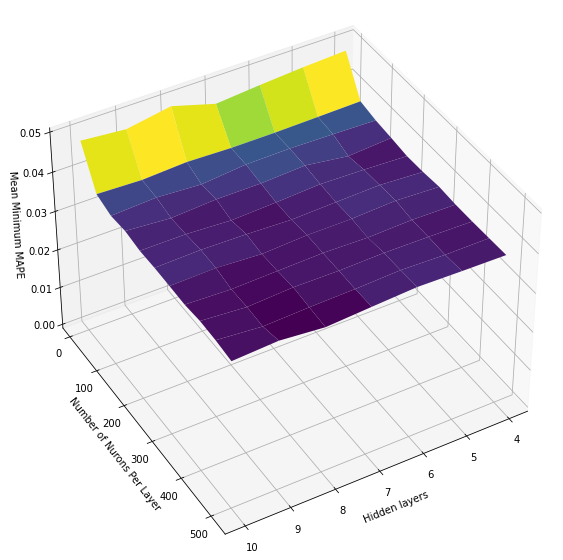

In [30]:

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(num_layers,layer_sizes_array,min_mape_mean,cmap = 'viridis')
#ax.scatter3D(3,18,min_mape_mean[3,3])
ax.view_init(40,60)
ax.set_xlabel('Hidden layers')
ax.set_ylabel('Number of Nurons Per Layer')
ax.set_zlabel('Mean Minimum MAPE')
ax.set_zlim(0,0.05)
#ax.set_xticks((range(4,8)))
#ax.set_yticks(range(24,29))

In [ ]:
fig.savefig('../Figures/Layers_best_400-600_4-10.png',dpi = 300)

In [ ]:
print('Optimised Layers =',num_layers[min_index],'Optimised Neuron_count= ', layer_sizes_array[min_index])
print('min_mae = ',np.min(min_mape_mean))

Optimised Layers = [8.] Optimised Neuron_count=  [510.]
min_mae =  0.03756286949656061
